### Notebook for looking at van der Meer's subduction zone configurations

- Load and reformat the data from van der Meer et al's previous studies, available here: http://geologist.nl/images/SBZDvdMetal2012.zip
- plot successive time snapshots together to see how the interpreted lines correspond from one snapshot to the next
- extract the distance of each subduction zone segment to the nearest point on the previous snapshot subduction zone configuration - this is a (sort of) proxy for the minimum migration rate of that point (when difference in age betweent the two snapshots is taken into account). Note however that appearance and disappearance of subduction zones could cause spuriously large migration rate. 
- plot the distribution of apparent migration rates form different time snapshots

In [1]:
import pygplates
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd

%matplotlib inline

rotation_model = pygplates.RotationModel('./MullerData/Global_EarthByte_230-0Ma_GK07_AREPS_VDM.rot')
static_polygon_filename = './MullerData/continental_polygons.gpmlz'

VDM2009_slablist = ['Aegean','Mongol-Okhotsk','Farallon','Ag','Al','At','Ba','Bf','Ca','CC',\
                'Ch','EC','Eg','GI','Hi','Id','Kc','Mc','Md','Me','Mg','NP','Ro','Sa','So',
                'TA','Ve','Wc']

# Make a list of all the files that constitute the van der Meer dataset
basedir = './vanderMeerData/'
file_list = glob.glob('%s/*.shp' % basedir)

file_list.sort()

# iterate over each feature each file, and populate lists that record the different ages and 
# feature names (ie the subduction zone names)
age_list = []
depth_list = []
blen_list = []
names_list = []


VDM2009_features = []
VDM2012_features = []


for filename in file_list:
    depth = float(filename[-16:-12])
    layer_radius = pygplates.Earth.mean_radius_in_kms-depth
    inferred_age = float(filename[-9:-6])
    age_list.append(inferred_age)
    depth_list.append(depth)

    features = pygplates.FeatureCollection(filename)

    blen = 0
    for feature in features:
        btype = feature.get_shapefile_attribute('Id')
        # Based on VDM files, the attribute 'btype' is an integer denoting boundary type, where
        # 1=1st to 3rd order subduction, 4=Flat-slab subduction, 5=Other subduction
        if btype==5 or btype==1 or btype==4:
            if feature.get_geometry() is not None:
                # Length has to be corrected for different layer radii  
                blen += feature.get_geometry().get_arc_length()*layer_radius
            names_list.append(feature.get_shapefile_attribute('name'))
            
            if feature.get_shapefile_attribute('name') in VDM2009_slablist:
                feature.set_name(feature.get_shapefile_attribute('name'))
                feature.set_valid_time(inferred_age+1.,inferred_age-1.)
                VDM2009_features.append(feature)
            else:
                feature.set_name(feature.get_shapefile_attribute('name'))
                feature.set_valid_time(inferred_age+1.,inferred_age-1.)
                VDM2012_features.append(feature)

    blen_list.append(blen)
    
# make a list that contains only the 'unique' subdution zone names (no duplication)
ds = pd.Series(names_list)
unique_slab_list = ds.sort_values().unique()


# Save to GPlates-readable feature collections
pygplates.FeatureCollection(VDM2009_features).write('./vanderMeerData/VDM2009_features.gpml')
pygplates.FeatureCollection(VDM2012_features).write('./vanderMeerData/VDM2012_features.gpml')


/Users/simon/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


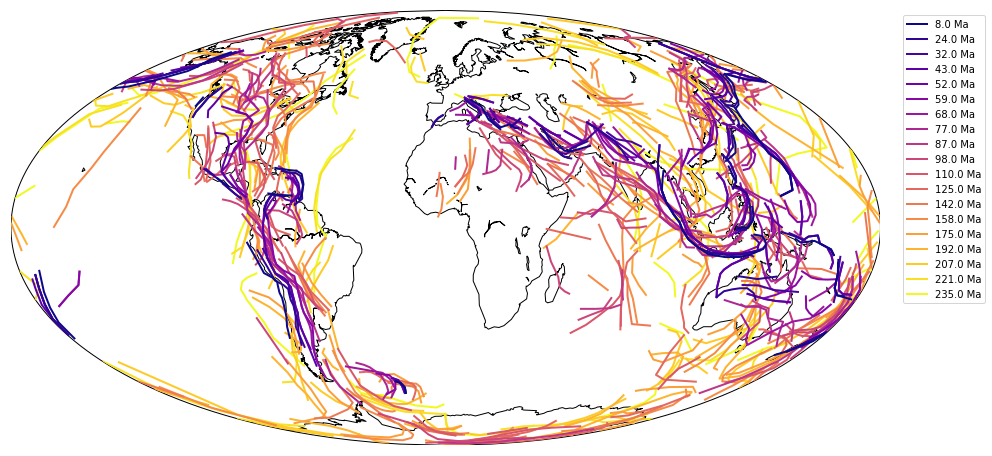

In [2]:
# Plot all subduction from different times as a single plot, color showing depth/age

plt.figure(figsize=(16,8))

m = Basemap(projection='moll',lon_0=0)
m.drawcoastlines()

color_idx = np.linspace(0, 1, len(file_list))

for i,filename in zip(color_idx,file_list):
    #dummy line plot to get legend
    plt.plot(-999,-999,color=plt.cm.plasma(i),
             linewidth=2,label='%s Ma' % float(filename[-9:-6]))
    features = pygplates.FeatureCollection(filename)
    for feature in features:
        btype = feature.get_shapefile_attribute('Id')
        if feature.get_geometry() is not None:
            points = feature.get_geometry().to_lat_lon_array()
            if btype==5 or btype==1 or btype==4: 
                x,y = m(points[:,1],points[:,0])
                m.plot(x,y,color=plt.cm.plasma(i),
                         linewidth=2,zorder=200-i)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()



In [12]:
# Get some files that represent the Earthbyte plate model reconstructed using the van der Meer reference frame.
# This way, we'll be able to reconstruct continent polygons to each time step, and measure the distance of each
# subduction zone to the nearest continent (at least based on the definition of continents provided by these polygons)


static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)

        
# Function to get distance to nearest continental polygon (should be reconstructed already)
def get_nearest_continental_polygon(seed_point,continental_polygons):
    
    min_distance_to_all_features = np.radians(180)
    nearest_continent = None        

    for polygon in continental_polygons:
        if polygon is not None:
            min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                polygon.get_reconstructed_geometry(),
                seed_point,
                min_distance_to_all_features,
                geometry1_is_solid=True)

            # If the current geometry is nearer than all previous geometries then
            # its associated feature is the nearest feature so far.
            if min_distance_to_feature is not None:
                min_distance_to_all_features = min_distance_to_feature
                nearest_continent = polygon.get_feature().get_reconstruction_plate_id()
                    
    return min_distance_to_all_features*pygplates.Earth.mean_radius_in_kms


def VDM_subduction(sz1,t1,sz_name_list):
    
    szLon = []
    szLat = []
    dist2cont = []
    time_list = []
    
    rtime = t1
    if rtime==235:
        rtime=231  # hack to workaround the relative rotations only reaching 231 Ma
    reconstructed_continental_polygons = []
    pygplates.reconstruct(static_polygon_features,
                  rotation_model,
                  reconstructed_continental_polygons,
                  rtime,
                  anchor_plate_id=0)
    
    for sz in sz1:
        if sz.get_shapefile_attribute('name') in sz_name_list:
            # resample segment to a more even distribution of points
            tesselated_segment = sz.get_geometry().to_tessellated(np.radians(0.1))
            for point in tesselated_segment:

                d2c = get_nearest_continental_polygon(point,reconstructed_continental_polygons)
                
                if d2c is not None:
                    szLon.append(point.to_lat_lon()[1])
                    szLat.append(point.to_lat_lon()[0])
                    dist2cont.append(d2c)
                    time_list.append(t1)
    
    return szLon,szLat,dist2cont,time_list
 
    
# define a function to locate the first or last appearance of a slab with a certain name
def subduction_startstop(flist,slablist,init_death):
# note that this function is not very computationally efficient, but since
# there are so few slabs to go through, not much point making it faster

    szLon=[]
    szLat=[]
    szd2c=[]
    sztime=[]
    
    DataFrameTemplate = ('lon','lat','dist2cont','Age')
    df_AllTimes = pd.DataFrame(columns=DataFrameTemplate)
    
    # iterate over each slab name in the list
    for slabname in slablist:
        
        # iterate over each file for each slabname, look for feature with 
        # slab name matching the current slab of interest
        for filename in flist:
            #dummy line plot to get legend
            features = pygplates.FeatureCollection(filename)
            for feature in features:
                btype = feature.get_shapefile_attribute('Id')
                if btype==5 or btype==1 or btype==4:
                    if feature.get_geometry() is not None:
                        points = feature.get_geometry().to_lat_lon_array()
                        if feature.get_shapefile_attribute('name')==slabname: 
                            # each time we get to here, the lastfile is updated
                            # but we only get to here if the slab is present at this time,
                            # so the last time we come through this if statement is the 
                            # birth time (or death if time order reversed)
                            lastfile = filename

        # Having completed the iteration to find the birth/death time, now focus on that 
        # one time and get the distance to continents
        if init_death=='init':
            excluded_time = '235'
        elif init_death=='death':
            excluded_time = '008'
        
        if lastfile[-9:-6]!=excluded_time:

            rtime = float(lastfile[-9:-6])
            if rtime==235:
                rtime=231  # hack to workaround the relative rotations only reaching 231 Ma
        
            reconstructed_continental_polygons = []
            pygplates.reconstruct(static_polygon_features,
                          rotation_model,
                          reconstructed_continental_polygons,
                          rtime,
                          anchor_plate_id=0)

            features = pygplates.FeatureCollection(lastfile)
            for feature in features:
                btype = feature.get_shapefile_attribute('Id')
                if btype==5 or btype==1 or btype==4:
                    if feature.get_geometry() is not None:
                        #points = feature.get_geometry().to_lat_lon_array()
                        if feature.get_shapefile_attribute('name')==slabname:
                            tesselated_segment = feature.get_geometry().to_tessellated(np.radians(0.1))

                            for point in tesselated_segment:
                                d2c = get_nearest_continental_polygon(point,reconstructed_continental_polygons)
                                szLon.append(point.to_lat_lon()[1])
                                szLat.append(point.to_lat_lon()[0])
                                szd2c.append(d2c)
                                sztime.append(float(lastfile[-9:-6]))
                        
        print slabname,lastfile[-9:-6]
        
        szdata=[]
        for item in zip(szLon,szLat,szd2c,sztime):
            szdata.append(item)
        df = pd.DataFrame(szdata, columns = DataFrameTemplate)
        df_AllTimes = df_AllTimes.append(df)
    
    return df_AllTimes


In [8]:
###########################

def all_subduction_distances(slabs_to_include):
    
    DataFrameTemplate = ('lon','lat','dist2cont','Age')
    df_AllTimes = pd.DataFrame(columns=DataFrameTemplate)
    
    for filename1 in file_list:

        print filename1

        sz1 = []
        features1 = pygplates.FeatureCollection(filename1)
        for feature in features1:
            btype = feature.get_shapefile_attribute('Id')
            if btype==5 or btype==1 or btype==4:
                if feature.get_geometry() is not None:
                    sz1.append(feature)

        szLon,szLat,dist2c,timel = VDM_subduction(sz1,
                                                  float(filename1[-9:-6]),
                                                  slabs_to_include)      

        szdata=[]
        for item in zip(szLon,szLat,dist2c,timel):
            szdata.append(item)
        df = pd.DataFrame(szdata, columns = DataFrameTemplate)

        df_AllTimes = df_AllTimes.append(df)
        
    return df_AllTimes
    

df_AllTimes = all_subduction_distances(unique_slab_list)
df_AllTimes.to_csv('./results/VDM_subduction_distances.csv')    


df_AllTimes = all_subduction_distances(VDM2009_slablist)
df_AllTimes.to_csv('./results/VDM_subduction_distances_2009list.csv')    


./vanderMeerData/SBZ0090km_008Ma.shp
./vanderMeerData/SBZ0285km_024Ma.shp
./vanderMeerData/SBZ0385km_032Ma.shp
./vanderMeerData/SBZ0500km_043Ma.shp
./vanderMeerData/SBZ0628km_052Ma.shp
./vanderMeerData/SBZ0710km_059Ma.shp
./vanderMeerData/SBZ0810km_068Ma.shp
./vanderMeerData/SBZ0920km_077Ma.shp
./vanderMeerData/SBZ1040km_087Ma.shp
./vanderMeerData/SBZ1175km_098Ma.shp
./vanderMeerData/SBZ1325km_110Ma.shp
./vanderMeerData/SBZ1500km_125Ma.shp
./vanderMeerData/SBZ1700km_142Ma.shp
./vanderMeerData/SBZ1900km_158Ma.shp
./vanderMeerData/SBZ2100km_175Ma.shp
./vanderMeerData/SBZ2300km_192Ma.shp
./vanderMeerData/SBZ2480km_207Ma.shp
./vanderMeerData/SBZ2650km_221Ma.shp
./vanderMeerData/SBZ2815km_235Ma.shp
./vanderMeerData/SBZ0090km_008Ma.shp
./vanderMeerData/SBZ0285km_024Ma.shp
./vanderMeerData/SBZ0385km_032Ma.shp
./vanderMeerData/SBZ0500km_043Ma.shp
./vanderMeerData/SBZ0628km_052Ma.shp
./vanderMeerData/SBZ0710km_059Ma.shp
./vanderMeerData/SBZ0810km_068Ma.shp
./vanderMeerData/SBZ0920km_077Ma.shp
.

In [13]:
file_list = sorted(glob.glob('%s/*.shp' % basedir))

#unique_slab_list
df_init = subduction_startstop(file_list,VDM2009_slablist,'init')
df_init.to_csv('./results/VDM_subduction_initiation.csv')

# Note that here we invert the (time) order of the list of files,
# so that we can iterate through and find 'subduction death' in the
# same way that we find initiation when the order is young-to-old
file_list = sorted(glob.glob('%s/*.shp' % basedir))
file_list.reverse() 
 
df_death = subduction_startstop(file_list,VDM2009_slablist,'death')
df_death.to_csv('./results/VDM_subduction_death.csv')



Aegean 158
Mongol-Okhotsk 235
Farallon 207
Ag 192
Al 068
At 235
Ba 235
Bf 192
Ca 068
CC 235
Ch 110
EC 235
Eg 110
GI 235
Hi 087
Id 192
Kc 077
Mc 068
Md 175
Me 175
Mg 142
NP 110
Ro 235
Sa 087
So 142
TA 235
Ve 098
Wc 221
Aegean 008
Mongol-Okhotsk 158
Farallon 077
Ag 125
Al 008
At 221
Ba 221
Bf 175
Ca 008
CC 125
Ch 110
EC 158
Eg 077
GI 125
Hi 024
Id 077
Kc 008
Mc 008
Md 077
Me 098
Mg 098
NP 077
Ro 221
Sa 077
So 098
TA 175
Ve 077
Wc 175
